# PyGIMLi - Electrical Resistivity Tomography

Using the ERT solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve the corresponding inverse problem.

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/pygimli_ert/pygimli_ert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/environment.yml) file
specifies a list of packages required to run the notebooks)

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !mamba install -c gimli pygimli=1.3

# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/notebooks/pygimli_ert

We will need the following packages:

- `numpy` for matrices and matrix-related functions
- `matplotlib` for plotting
- `pygimli` for forward modelling of the problem
- `cofi` for accessing different inference solvers

Additionally, we wrap some `pygimli` code in file `pygimli_ert_lib.py` and import it
here for conciseness.

In [2]:
import numpy as np
import pygimli
from pygimli.physics import ert

from cofi import BaseProblem, InversionOptions, Inversion
from cofi.solvers import BaseSolver

from pygimli_ert_lib import *

np.random.seed(42)

## 1. Define the problem

We first define the true model, the survey and map it on a computational mesh designed for the survey and true anomaly.

Text(0.5, 1.0, 'True model')

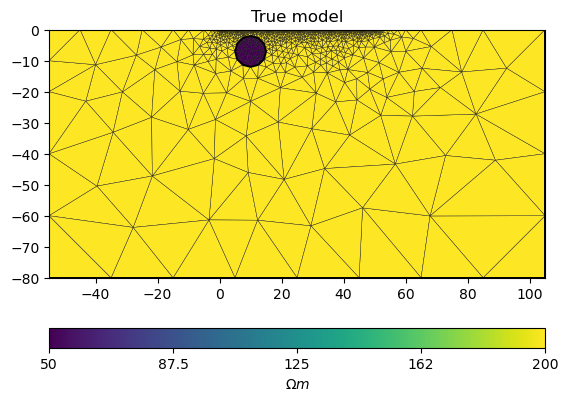

In [3]:
# PyGIMLi - define measuring scheme, geometry, forward mesh and true model
scheme = survey_scheme()
mesh, rhomap = model_true(scheme)

# plot the true model
ax = pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True)
ax[0].set_title("True model")

Generate the synthetic data as a container with all the necessary information for plotting.

In ERT problems, the model and data are by convention treated in log space. 

14/09/22 - 11:13:32 - pyGIMLi - INFO - Calculate geometric factors.


ModellingBase::setMesh() copying new mesh ... Found datafile: 51 electrodes
Found: 51 free-electrodes
rMin = 0.5, rMax = 100
NGauLeg + NGauLag for inverse Fouriertransformation: 13 + 4
Found non-Neumann domain
0.012 s
FOP updating mesh dependencies ... 0 s
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.010009229451098493 : 0.22552739004919173
Obtaining geometric factors (analytical)
Calculating response for model: min = 50 max = 200
Allocating memory for primary potential...... 0.003

No primary potential for secondary field calculation. Calculating analytically...
Factorize (Cholmod) matrix ... 0.006
Factorize (Cholmod) matrix ... 0.005
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.005
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factorize (Cholmod) matrix ... 0.004
Factoriz

Text(0.5, 1.0, 'Provided data')

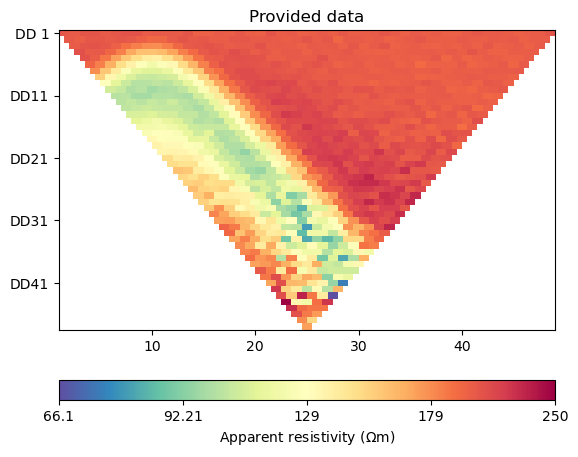

In [4]:
# PyGIMLi - generate data
data, log_data, data_cov_inv = ert_simulate(mesh, scheme, rhomap)

ax = ert.show(data)
ax[0].set_title("Provided data")

Further, we create a `pygimli.ert.ERTManager` instance to keep record of problem-specific
information like the inversion mesh, and to perform forward operation for the inversion
solvers.

In [5]:
# create PyGIMLi's ERT manager
ert_manager = ert_manager(data)

The inversion can use a different mesh and the mesh to be used should know nothing about the mesh that was designed based on the true model. We wrap two kinds of mesh as examples in the library code `pygimli_ert_lib.py`, namely triangular and rectangular mesh.

Use `imesh_tri = inversion_mesh(scheme)` to initialise a triangular mesh. This function uses PyGIMLi's own mesh generator
and generates triangular mesh automatically from given sensor locations. The resulting mesh will have a smaller area as 
unknowns to be inverted, as well as a background part with values prolongated outside from the parametric domain by PyGIMLi.
You will see an example plot in the code cell below. 

Use `imesh_rect = inversion_mesh_rect(ert_manager)` to initislise a rectangular mesh. The grid mesh is created from these x and y
nodes: `x = np.linspace(start=-5, stop=55, num=61)`, and `y = np.linspace(start=-20,stop=0,num=10)`. And again, there's a triangular
background with values prolongated outside from the parametric domain by PyGIMLi.

Here we first demonstrate how to use a *triangular mesh*. Note that this makes the inversion problem under-determined.

14/09/22 - 11:13:32 - pyGIMLi - INFO - Found 2 regions.


14/09/22 - 11:13:32 - pyGIMLi - INFO - Region with smallest marker (1) set to background


Text(0.5, 1.0, 'Mesh used for inversion')

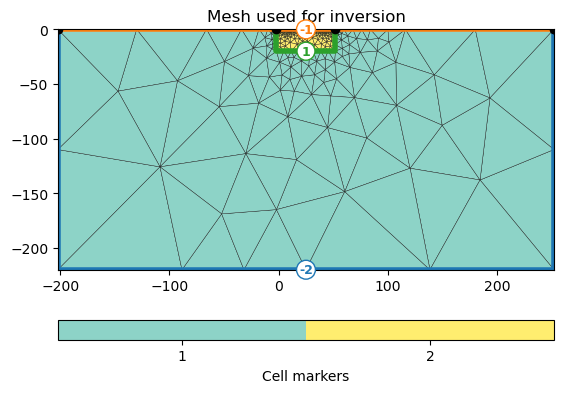

In [6]:
inv_mesh = inversion_mesh(ert_manager)
ax = pygimli.show(inv_mesh, showMesh=True, markers=True)
ax[0].set_title("Mesh used for inversion")

[This folder](https://github.com/inlab-geo/cofi-examples/tree/main/notebooks/pygimli_ert)
contains examples scripts that run inversion for triangular or rectangular meshes, with 
different inversion approaches.

With the inversion mesh created, we now define a starting model, forward operator and 
weighting matrix for regularisation using PyGIMLi.

Recall that both our model and data will be in log space when we perform inversion.

14/09/22 - 11:13:33 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.


14/09/22 - 11:13:33 - Core - WARNING - Region Nr: 1  is background and should not get a model control.


14/09/22 - 11:13:33 - pyGIMLi - INFO - Creating forward mesh from region infos.


14/09/22 - 11:13:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Text(0.5, 1.0, 'Starting model')

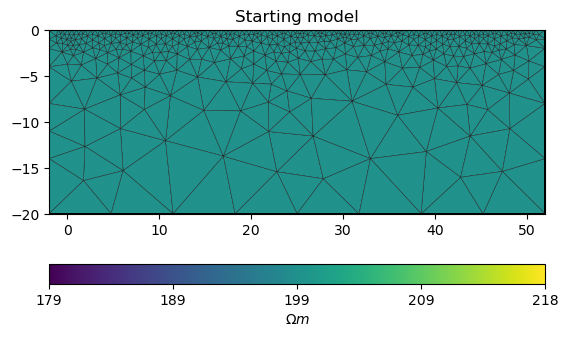

In [7]:
# PyGIMLi's forward operator (ERTModelling)
forward_oprt = ert_forward_operator(ert_manager, scheme, inv_mesh)

# extract regularisation matrix
Wm = reg_matrix(forward_oprt)

# initialise a starting model for inversion
start_model, start_model_log = starting_model(ert_manager)
ax = pygimli.show(ert_manager.paraDomain, data=start_model, label="$\Omega m$", showMesh=True)
ax[0].set_title("Starting model")

CoFI and other inference packages require a set of functions that provide the misfit, the jacobian the residual within the case of scipy standardised interfaces. All these functions are defined in the library file `pygimli_ert_lib.py`, so open this file if you'd like to find out the details. These functions are:

- `get_response`
- `get_jacobian`
- `get_residuals`
- `get_data_misfit`
- `get_regularisation`
- `get_gradient`
- `get_hessian`

With all the above forward operations set up with PyGIMLi, we now define the problem in `cofi`
by setting the problem information for a `BaseProblem` object.

In [8]:
# hyperparameters
lamda = 0.0001

# CoFI - define BaseProblem
ert_problem = BaseProblem()
ert_problem.name = "Electrical Resistivity Tomography defined through PyGIMLi"
ert_problem.set_forward(get_response, args=[forward_oprt])
ert_problem.set_jacobian(get_jacobian, args=[forward_oprt])
ert_problem.set_residual(get_residual, args=[log_data, forward_oprt])
ert_problem.set_data_misfit(get_data_misfit, args=[log_data, forward_oprt, data_cov_inv])
ert_problem.set_regularisation(get_regularisation, args=[Wm, lamda])
ert_problem.set_gradient(get_gradient, args=[log_data, forward_oprt, Wm, lamda, data_cov_inv])
ert_problem.set_hessian(get_hessian, args=[log_data, forward_oprt, Wm, lamda, data_cov_inv])
ert_problem.set_initial_model(start_model_log)

Review what information is included in the `BaseProblem` object:

In [9]:
ert_problem.summary()

Summary for inversion problem: Electrical Resistivity Tomography defined through PyGIMLi
Model shape: (831,)
----------------------------------------------------------------------------------------
List of functions/properties set by you:
['gradient', 'hessian', 'residual', 'jacobian', 'data_misfit', 'regularisation', 'regularisation_factor', 'forward', 'initial_model', 'model_shape']
----------------------------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['objective', 'hessian_times_vector', 'jacobian_times_vector']
----------------------------------------------------------------------------------------
List of functions/properties not set by you:
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'hessian_times_vector', 'jacobian_times_vector', 'regularisation_matrix', 'data', 'data_covariance', 'data_covariance_inv', 'walkers_starting_pos', 'blobs_dtype', 'bo

## 2. Define the inversion options and run

### 2.1 SciPy's optimiser ([trust-exact](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-trustexact.html#optimize-minimize-trustexact))

In [10]:
ert_problem.suggest_solvers();

Based on what you've provided so far, here are possible solvers:
{
    "optimisation": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares"
    ],
    "linear least square": [],
    "sampling": []
}


In [11]:
inv_options_scipy = InversionOptions()
inv_options_scipy.set_tool("scipy.optimize.minimize")
inv_options_scipy.set_params(method="trust-exact")

Review what's been defined for the inversion we are about to run:

In [12]:
inv_options_scipy.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.optimize.minimize` - SciPy's optimisers that minimises a scalar function with respect to one or more variables, check SciPy's documentation page for a list of methods
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: 
method = trust-exact
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [13]:
inv = Inversion(ert_problem, inv_options_scipy)
inv_result = inv.run()
inv_result.summary()

/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.10/site-packages/scipy/optimize/_minimize.py:561: RuntimeWarning: Method trust-exact does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '


Summary for inversion result
FAILURE
----------------------------
status: 2
fun: 4.960150890082124
jac: [-5.30112881e-06  3.79735804e-06 -8.60678515e-06 -9.29703412e-07
 -1.35212257e-07 -6.92638109e-06 -4.06051481e-05 -8.70987717e-07
 -2.90934300e-06  2.12038820e-05  1.20998195e-05 -2.78334060e-06
 -9.50496144e-07 -4.45354803e-06 -1.91308424e-07 -1.19127121e-05
 -1.40773563e-06  5.28114695e-06  8.94591738e-06 -2.06313916e-06
 -2.37700856e-05  4.38322305e-06  2.39064726e-06  1.85474155e-05
 -2.79459082e-05  4.65908802e-06 -8.76807851e-06 -1.05235361e-05
 -4.88682530e-06 -1.37916605e-05 -8.40502722e-07  7.33128586e-06
  1.91645229e-05  9.23841166e-06 -8.21060621e-06  2.89024906e-06
 -2.79933975e-06  3.28224853e-06 -3.95669101e-06  4.34430941e-06
 -2.20105570e-06  4.45791863e-06  9.06964179e-06 -3.07840676e-06
  1.96862324e-06  7.13069571e-07  5.42631525e-06 -6.27320361e-06
  1.76465782e-06 -7.89287204e-06 -4.67028958e-06  7.72920753e-06
  1.55266814e-05  2.68361180e-06 -3.56794378e-06  5

In [14]:
inv_result.success

False

Plot the results:

Summary for inversion result
FAILURE
----------------------------
status: 2
fun: 4.960150890082124
jac: [-5.30112881e-06  3.79735804e-06 -8.60678515e-06 -9.29703412e-07
 -1.35212257e-07 -6.92638109e-06 -4.06051481e-05 -8.70987717e-07
 -2.90934300e-06  2.12038820e-05  1.20998195e-05 -2.78334060e-06
 -9.50496144e-07 -4.45354803e-06 -1.91308424e-07 -1.19127121e-05
 -1.40773563e-06  5.28114695e-06  8.94591738e-06 -2.06313916e-06
 -2.37700856e-05  4.38322305e-06  2.39064726e-06  1.85474155e-05
 -2.79459082e-05  4.65908802e-06 -8.76807851e-06 -1.05235361e-05
 -4.88682530e-06 -1.37916605e-05 -8.40502722e-07  7.33128586e-06
  1.91645229e-05  9.23841166e-06 -8.21060621e-06  2.89024906e-06
 -2.79933975e-06  3.28224853e-06 -3.95669101e-06  4.34430941e-06
 -2.20105570e-06  4.45791863e-06  9.06964179e-06 -3.07840676e-06
  1.96862324e-06  7.13069571e-07  5.42631525e-06 -6.27320361e-06
  1.76465782e-06 -7.89287204e-06 -4.67028958e-06  7.72920753e-06
  1.55266814e-05  2.68361180e-06 -3.56794378e-06  5

Text(0.5, 1.0, 'Inferred model')

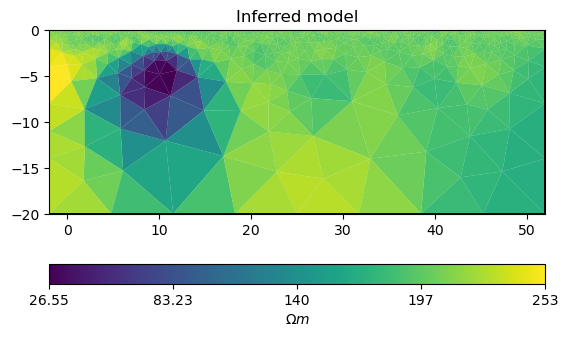

In [15]:
# convert back to normal space from log space
model = np.exp(inv_result.model)

# plot inferred model
inv_result.summary()
ax = pygimli.show(ert_manager.paraDomain, data=model, label=r"$\Omega m$")
ax[0].set_title("Inferred model")

Text(0.5, 1.0, 'Synthetic data from inferred model')

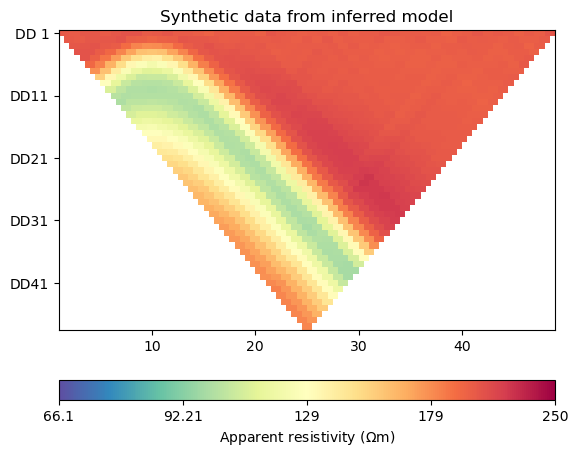

In [16]:
# plot synthetic data
d = forward_oprt.response(model)
ax = ert.showERTData(scheme, vals=d, cMin=np.min(data["rhoa"]), cMax=np.max(data["rhoa"]))
ax[0].set_title("Synthetic data from inferred model")

### 2.2 A custom [Newton's optimisation](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) approach

Now we switch to a Newton's iterative approach written by ourselves, so you'll 
have a closer look at what's happening in the loop.

First of all, define our own solver.

In [17]:
class GaussNewton(BaseSolver):
    def __init__(self, inv_problem, inv_options):
        __params = inv_options.get_params()
        self._niter = __params.get("niter", 100)
        self._verbose = __params.get("verbose", True)
        self._step = __params.get("step", 1)
        self._model_0 = inv_problem.initial_model
        self._residual = inv_problem.residual
        self._jacobian = inv_problem.jacobian
        self._gradient = inv_problem.gradient
        self._hessian = inv_problem.hessian
        self._misfit = inv_problem.data_misfit if inv_problem.data_misfit_defined else None
        self._reg = inv_problem.regularisation if inv_problem.regularisation_defined else None
        self._obj = inv_problem.objective if inv_problem.objective_defined else None

    def __call__(self):
        current_model = np.array(self._model_0)
        for i in range(self._niter):
            if self._verbose:
                print("-" * 80)
                print(f"Iteration {i+1}")
                print("model min and max:", np.min(current_model), np.max(current_model))
                if self._misfit: print("data misfit:", self._misfit(current_model))
                if self._reg: print("regularisation:", self._reg(current_model))
            term1 = self._hessian(current_model)
            term2 = - self._gradient(current_model)
            model_update = np.linalg.solve(term1, term2) * self._step
            current_model = current_model + model_update
        return {"model": current_model, "success": True}

Now, make use of this custom solver and run inversion again:

In [18]:
# hyperparameters
lamda = 0.0001
niter = 150
inv_verbose = True
step = 0.005

# CoFI - define InversionOptions
inv_options = InversionOptions()
inv_options.set_tool(GaussNewton)
inv_options.set_params(niter=niter, verbose=inv_verbose, step=step)

# CoFI - define Inversion, run it
inv = Inversion(ert_problem, inv_options)
inv_result = inv.run()

--------------------------------------------------------------------------------
Iteration 1
model min and max: 5.291310843489913 5.291310843489913


data misfit: 229.71418345445022
regularisation: 0.0


--------------------------------------------------------------------------------
Iteration 2
model min and max: 5.275884701683011 5.304449604934316


data misfit: 227.23411332788962
regularisation: 0.010102187048026049


--------------------------------------------------------------------------------
Iteration 3
model min and max: 5.262031885900378 5.310706445057153
data misfit: 224.88018892913274
regularisation: 0.023828812726472533


--------------------------------------------------------------------------------
Iteration 4
model min and max: 5.248398551565876 5.315148641783872
data misfit: 222.5841638420562
regularisation: 0.03833074053504775


--------------------------------------------------------------------------------
Iteration 5
model min and max: 5.235210460904438 5.318970381278622
data misfit: 220.32501943579953
regularisation: 0.05346144871864931


--------------------------------------------------------------------------------
Iteration 6
model min and max: 5.221988655748763 5.322505463475772
data misfit: 218.09539040624733
regularisation: 0.06913735737871443


--------------------------------------------------------------------------------
Iteration 7
model min and max: 5.208735295257294 5.32586064835052


data misfit: 215.892125425656
regularisation: 0.08529292762626417


--------------------------------------------------------------------------------
Iteration 8
model min and max: 5.195697353190826 5.329074034023208
data misfit: 213.71361019906533
regularisation: 0.10188094041725626


--------------------------------------------------------------------------------
Iteration 9
model min and max: 5.182852523974125 5.33216135580181


data misfit: 211.5588753156785
regularisation: 0.11886698952398339


--------------------------------------------------------------------------------
Iteration 10
model min and max: 5.170183680332095 5.335368509288966


data misfit: 209.4272561757092
regularisation: 0.13622406025922246


--------------------------------------------------------------------------------
Iteration 11
model min and max: 5.157677506123936 5.3386873547566545


data misfit: 207.3182453718031
regularisation: 0.15392888174432326


--------------------------------------------------------------------------------
Iteration 12
model min and max: 5.145323421153358 5.34186306768169
data misfit: 205.23142386946935
regularisation: 0.17195977704253437


--------------------------------------------------------------------------------
Iteration 13
model min and max: 5.133112822085492 5.344904921855511
data misfit: 203.1664249261597
regularisation: 0.19029556215921561


--------------------------------------------------------------------------------
Iteration 14
model min and max: 5.12103856564546 5.34782217993657
data misfit: 201.12291605687238
regularisation: 0.20891505260317994


--------------------------------------------------------------------------------
Iteration 15
model min and max: 5.1090946125734575 5.3506238993765205
data misfit: 199.1005873204019
regularisation: 0.22779693654237623


--------------------------------------------------------------------------------
Iteration 16
model min and max: 5.0972757762238015 5.353318771425228
data misfit: 197.09914546356381
regularisation: 0.24691982779311505


--------------------------------------------------------------------------------
Iteration 17
model min and max: 5.085577543217933 5.35591503749741
data misfit: 195.1183106780502
regularisation: 0.266262401430304


--------------------------------------------------------------------------------
Iteration 18
model min and max: 5.0739959425518 5.358420418112907
data misfit: 193.15781346330175
regularisation: 0.2858035601446564


--------------------------------------------------------------------------------
Iteration 19
model min and max: 5.062527443232834 5.360842098922075
data misfit: 191.21739387575644
regularisation: 0.305522597185297


--------------------------------------------------------------------------------
Iteration 20
model min and max: 5.051168876563569 5.363186710301079
data misfit: 189.29679965235673
regularisation: 0.3253993358788451


--------------------------------------------------------------------------------
Iteration 21
model min and max: 5.039917379336079 5.365460364164342


data misfit: 187.3957862579242
regularisation: 0.3454142459680997


--------------------------------------------------------------------------------
Iteration 22
model min and max: 5.028770340584718 5.3676686561213645
data misfit: 185.514115785678
regularisation: 0.36554853574057805


--------------------------------------------------------------------------------
Iteration 23
model min and max: 5.017725368281747 5.369816711228191
data misfit: 183.65155678774858
regularisation: 0.38578421008581354


--------------------------------------------------------------------------------
Iteration 24
model min and max: 5.006780251444899 5.371909207551852
data misfit: 181.80788344019362
regularisation: 0.4061041302254167


--------------------------------------------------------------------------------
Iteration 25
model min and max: 4.99593294129432 5.373950416869972


data misfit: 179.9828755687684
regularisation: 0.4264920217833231


--------------------------------------------------------------------------------
Iteration 26
model min and max: 4.985181525464334 5.375944233954563


data misfit: 178.17631801144034
regularisation: 0.44693249952342323


--------------------------------------------------------------------------------
Iteration 27
model min and max: 4.974524211269064 5.377894212825977
data misfit: 176.3880007794431
regularisation: 0.46741105465125105


--------------------------------------------------------------------------------
Iteration 28
model min and max: 4.963959312536056 5.3798035934133965


data misfit: 174.61771808953412
regularisation: 0.487914048221482


--------------------------------------------------------------------------------
Iteration 29
model min and max: 4.953485236087738 5.381675329745837
data misfit: 172.8652685564188
regularisation: 0.5084287005330721


--------------------------------------------------------------------------------
Iteration 30
model min and max: 4.9431004710643505 5.3835121200451725


data misfit: 171.13045503046692
regularisation: 0.5289430509055988


--------------------------------------------------------------------------------
Iteration 31
model min and max: 4.932803581903644 5.385316428691364
data misfit: 169.41308383642195
regularisation: 0.5494459457261778


--------------------------------------------------------------------------------
Iteration 32
model min and max: 4.922593199750816 5.387090509279762
data misfit: 167.71296524705306
regularisation: 0.5699269969763047


--------------------------------------------------------------------------------
Iteration 33
model min and max: 4.912468014404285 5.3888364231022114
data misfit: 166.02991298112045
regularisation: 0.5903765548599054


--------------------------------------------------------------------------------
Iteration 34
model min and max: 4.902426771555987 5.390556051427905
data misfit: 164.36374380365098
regularisation: 0.6107856710417556


--------------------------------------------------------------------------------
Iteration 35
model min and max: 4.892468266762715 5.392251128496479
data misfit: 162.71427750170972
regularisation: 0.6311460715487077


--------------------------------------------------------------------------------
Iteration 36
model min and max: 4.882591341300616 5.393923238140581
data misfit: 161.0813373059921
regularisation: 0.6514501102000767


--------------------------------------------------------------------------------
Iteration 37
model min and max: 4.872794877802553 5.395573836387058
data misfit: 159.46474886077266
regularisation: 0.6716907506294206


--------------------------------------------------------------------------------
Iteration 38
model min and max: 4.863077799232184 5.397204260303231
data misfit: 157.86434051758454
regularisation: 0.6918615228984512


--------------------------------------------------------------------------------
Iteration 39
model min and max: 4.853439062981364 5.398815737638305
data misfit: 156.27994362813175
regularisation: 0.7119564895261061


--------------------------------------------------------------------------------
Iteration 40
model min and max: 4.843877660539999 5.400409404939443
data misfit: 154.7113914392031
regularisation: 0.7319702319953137


--------------------------------------------------------------------------------
Iteration 41
model min and max: 4.834392614595396 5.401986306119138
data misfit: 153.1585200053411
regularisation: 0.751897796223306


--------------------------------------------------------------------------------
Iteration 42
model min and max: 4.824982976985505 5.403547402018978
data misfit: 151.62116734960452
regularisation: 0.7717346840168342


--------------------------------------------------------------------------------
Iteration 43
model min and max: 4.815647827351711 5.405093589754645
data misfit: 150.09917404040849
regularisation: 0.7914768181139261


--------------------------------------------------------------------------------
Iteration 44
model min and max: 4.806386269092722 5.406625684916964
data misfit: 148.59238263640933
regularisation: 0.8111205127409242


--------------------------------------------------------------------------------
Iteration 45
model min and max: 4.797197431706711 5.4081444492277875
data misfit: 147.10063776580796
regularisation: 0.8306624530384038


--------------------------------------------------------------------------------
Iteration 46
model min and max: 4.788080466379233 5.409650589184678
data misfit: 145.6237860243799
regularisation: 0.8500996723663843


--------------------------------------------------------------------------------
Iteration 47
model min and max: 4.779034546606621 5.411144754330455
data misfit: 144.1616760628408
regularisation: 0.869429526352276


--------------------------------------------------------------------------------
Iteration 48
model min and max: 4.77005886517078 5.4126275522111165
data misfit: 142.71415837624176
regularisation: 0.8886496780314453


--------------------------------------------------------------------------------
Iteration 49
model min and max: 4.7611526349220386 5.414099547408319


data misfit: 141.28108507204146
regularisation: 0.9077580699494672


--------------------------------------------------------------------------------
Iteration 50
model min and max: 4.752315086329398 5.415561259851664
data misfit: 139.86231043937474
regularisation: 0.9267529054781188


--------------------------------------------------------------------------------
Iteration 51
model min and max: 4.743545468725472 5.417013174828796


data misfit: 138.4576902451595
regularisation: 0.9456326378932499


--------------------------------------------------------------------------------
Iteration 52
model min and max: 4.734843045652011 5.418455745995548
data misfit: 137.0670820466871
regularisation: 0.9643959505529218


--------------------------------------------------------------------------------
Iteration 53
model min and max: 4.726207099023001 5.4198893984012555
data misfit: 135.69034512639965
regularisation: 0.9830417403567703


--------------------------------------------------------------------------------
Iteration 54
model min and max: 4.717636923781003 5.421314518653016
data misfit: 134.32734005793296
regularisation: 1.0015690966183368


--------------------------------------------------------------------------------
Iteration 55
model min and max: 4.709131830086291 5.422731475877268
data misfit: 132.9779295692208
regularisation: 1.0199772893835737


--------------------------------------------------------------------------------
Iteration 56
model min and max: 4.70069114243283 5.424140613264984


data misfit: 131.64197733763353
regularisation: 1.0382657738390224


--------------------------------------------------------------------------------
Iteration 57
model min and max: 4.6923141972530615 5.425542250593246
data misfit: 130.3193490218099
regularisation: 1.0564341506472488


--------------------------------------------------------------------------------
Iteration 58
model min and max: 4.68400034517704 5.4269366873379346
data misfit: 129.0099116150112
regularisation: 1.0744821685378754


--------------------------------------------------------------------------------
Iteration 59
model min and max: 4.675748947098405 5.428324198049591
data misfit: 127.71353343911387
regularisation: 1.0924097120764973


--------------------------------------------------------------------------------
Iteration 60
model min and max: 4.667559377075943 5.4297050507170415
data misfit: 126.43008461789586
regularisation: 1.1102167898712543


--------------------------------------------------------------------------------
Iteration 61
model min and max: 4.659431019632144 5.431079485201721
data misfit: 125.15943610782304
regularisation: 1.1279035252465577


--------------------------------------------------------------------------------
Iteration 62
model min and max: 4.651363270487258 5.432447733346097
data misfit: 123.90146088553449
regularisation: 1.1454701438206103


--------------------------------------------------------------------------------
Iteration 63
model min and max: 4.6433555361267596 5.433810014739984
data misfit: 122.6560328783673
regularisation: 1.1629169744660792


--------------------------------------------------------------------------------
Iteration 64
model min and max: 4.635407231730734 5.435166525301702
data misfit: 121.42302740112454
regularisation: 1.180244427327086


--------------------------------------------------------------------------------
Iteration 65
model min and max: 4.627517783787276 5.4365174588685905
data misfit: 120.20232132669571
regularisation: 1.1974529992927707


--------------------------------------------------------------------------------
Iteration 66
model min and max: 4.61968662687178 5.437862988270548
data misfit: 118.99379251676498
regularisation: 1.2145432558775742


--------------------------------------------------------------------------------
Iteration 67
model min and max: 4.611913205864331 5.4392032858974675


data misfit: 117.79732043902516
regularisation: 1.2315158348673299


--------------------------------------------------------------------------------
Iteration 68
model min and max: 4.604196972835468 5.4405385077424055
data misfit: 116.61278550186493
regularisation: 1.2483714297315704


--------------------------------------------------------------------------------
Iteration 69
model min and max: 4.596537389260186 5.44186879876963
data misfit: 115.4400695986893
regularisation: 1.2651107953642442


--------------------------------------------------------------------------------
Iteration 70
model min and max: 4.588933924906129 5.443194305164025


data misfit: 114.27905560311517
regularisation: 1.2817347331320352


--------------------------------------------------------------------------------
Iteration 71
model min and max: 4.581386057254373 5.444515152949651


data misfit: 113.12962777685908
regularisation: 1.2982440852738948


--------------------------------------------------------------------------------
Iteration 72
model min and max: 4.573893271416119 5.4458314621212285
data misfit: 111.99167167496597
regularisation: 1.3146397419426792


--------------------------------------------------------------------------------
Iteration 73
model min and max: 4.566455060606258 5.447143355528816
data misfit: 110.86507371042079
regularisation: 1.330922623759119


--------------------------------------------------------------------------------
Iteration 74
model min and max: 4.559070924813917 5.44845094126685


data misfit: 109.74972168905651
regularisation: 1.3470936855258475


--------------------------------------------------------------------------------
Iteration 75
model min and max: 4.551740370186375 5.4497543152236485


data misfit: 108.64550462298934
regularisation: 1.3631539059628426


--------------------------------------------------------------------------------
Iteration 76
model min and max: 4.5444629109085435 5.451053583547223


data misfit: 107.552312402364
regularisation: 1.3791042909357187


--------------------------------------------------------------------------------
Iteration 77
model min and max: 4.537238068038325 5.452348833713711
data misfit: 106.47003619955336
regularisation: 1.3949458653028175


--------------------------------------------------------------------------------
Iteration 78
model min and max: 4.530065368466229 5.453640151818663
data misfit: 105.39856824352779
regularisation: 1.4106796759031328


--------------------------------------------------------------------------------
Iteration 79
model min and max: 4.5229443454238405 5.454927619238036


data misfit: 104.33780180995203
regularisation: 1.426306778087154


--------------------------------------------------------------------------------
Iteration 80
model min and max: 4.5158745378381315 5.4562113109785075
data misfit: 103.28763128559409
regularisation: 1.441828240090048


--------------------------------------------------------------------------------
Iteration 81
model min and max: 4.508855493270218 5.457491300845515
data misfit: 102.24795227460832
regularisation: 1.4572451454483974


--------------------------------------------------------------------------------
Iteration 82
model min and max: 4.50188676187929 5.458767657970932
data misfit: 101.21866112882478
regularisation: 1.4725585816227456


--------------------------------------------------------------------------------
Iteration 83
model min and max: 4.494967901318093 5.460040446671436
data misfit: 100.19965538774181
regularisation: 1.4877696412919403


--------------------------------------------------------------------------------
Iteration 84
model min and max: 4.488098473702941 5.4613097231225485
data misfit: 99.19083378845299
regularisation: 1.502879418795527


--------------------------------------------------------------------------------
Iteration 85
model min and max: 4.481278048430551 5.462575547451118
data misfit: 98.19209570727084
regularisation: 1.5178890100537819


--------------------------------------------------------------------------------
Iteration 86
model min and max: 4.474506198985969 5.463837975812675


data misfit: 97.20334176265787
regularisation: 1.5327995203037


--------------------------------------------------------------------------------
Iteration 87
model min and max: 4.467782504131351 5.465097054742372
data misfit: 96.22447356239108
regularisation: 1.5476120398863975


--------------------------------------------------------------------------------
Iteration 88
model min and max: 4.461106547429185 5.466352832166504
data misfit: 95.25539353083107
regularisation: 1.5623276606878707


--------------------------------------------------------------------------------
Iteration 89
model min and max: 4.454477917852457 5.467605355818298
data misfit: 94.29600528769339
regularisation: 1.576947477050529


--------------------------------------------------------------------------------
Iteration 90
model min and max: 4.447896209597973 5.468854667023702
data misfit: 93.34621325777489
regularisation: 1.5914725697351697


--------------------------------------------------------------------------------
Iteration 91
model min and max: 4.441361021254639 5.470100804738428
data misfit: 92.40592294458668
regularisation: 1.6059040139232905


--------------------------------------------------------------------------------
Iteration 92
model min and max: 4.43487195684533 5.471343807998605
data misfit: 91.47504046287128
regularisation: 1.6202428834732538


--------------------------------------------------------------------------------
Iteration 93
model min and max: 4.428428622778496 5.4725837089775995
data misfit: 90.55347314896551
regularisation: 1.6344902333539184


--------------------------------------------------------------------------------
Iteration 94
model min and max: 4.4220306328711585 5.473820544583677
data misfit: 89.64112924285119
regularisation: 1.6486471175990582


--------------------------------------------------------------------------------
Iteration 95
model min and max: 4.415677603772626 5.47505434565775
data misfit: 88.73791789694776
regularisation: 1.662714583579125


--------------------------------------------------------------------------------
Iteration 96
model min and max: 4.409369156141778 5.476285137003964


data misfit: 87.84374880995206
regularisation: 1.6766936565901804


--------------------------------------------------------------------------------
Iteration 97
model min and max: 4.403104916155879 5.4775129502885544
data misfit: 86.95853313942787
regularisation: 1.690585358556468


--------------------------------------------------------------------------------
Iteration 98
model min and max: 4.39688451354931 5.478737814007189
data misfit: 86.08218249025609
regularisation: 1.7043907022673535


--------------------------------------------------------------------------------
Iteration 99
model min and max: 4.390707580980985 5.479959743130019


data misfit: 85.21460937810053
regularisation: 1.7181106804167705


--------------------------------------------------------------------------------
Iteration 100
model min and max: 4.3845737572929835 5.481178772923998


data misfit: 84.35572743571626
regularisation: 1.7317462762735651


--------------------------------------------------------------------------------
Iteration 101
model min and max: 4.378482683850396 5.482394915551317


data misfit: 83.50545076869427
regularisation: 1.7452984675777568


--------------------------------------------------------------------------------
Iteration 102
model min and max: 4.372434005712405 5.483608192046762


data misfit: 82.66369488589048
regularisation: 1.7587682050265108


--------------------------------------------------------------------------------
Iteration 103
model min and max: 4.366427372981393 5.484818622802273
data misfit: 81.83037531711092
regularisation: 1.77215644111403


--------------------------------------------------------------------------------
Iteration 104
model min and max: 4.36046243884271 5.486026226689294


data misfit: 81.00540905874284
regularisation: 1.7854641025202056


--------------------------------------------------------------------------------
Iteration 105
model min and max: 4.354538859621489 5.487231017752785
data misfit: 80.18871373270579
regularisation: 1.798692107865697


--------------------------------------------------------------------------------
Iteration 106
model min and max: 4.348656295548764 5.488433010948002
data misfit: 79.3802078191352
regularisation: 1.8118413588832685


--------------------------------------------------------------------------------
Iteration 107
model min and max: 4.342814410670075 5.489632220254631


data misfit: 78.5798104960511
regularisation: 1.8249127494809203


--------------------------------------------------------------------------------
Iteration 108
model min and max: 4.337012873230247 5.490828661824105
data misfit: 77.78744159022175
regularisation: 1.8379071543271472


--------------------------------------------------------------------------------
Iteration 109
model min and max: 4.331251353227135 5.492022342221712
data misfit: 77.0030221191503
regularisation: 1.8508254342865766


--------------------------------------------------------------------------------
Iteration 110
model min and max: 4.325529525685192 5.493213276526542
data misfit: 76.2264735868664
regularisation: 1.8636684387178917


--------------------------------------------------------------------------------
Iteration 111
model min and max: 4.319847067333837 5.4944014697764265


data misfit: 75.45771830630939
regularisation: 1.8764369944170802


--------------------------------------------------------------------------------
Iteration 112
model min and max: 4.314203660311582 5.495586942374595
data misfit: 74.69667928818569
regularisation: 1.8891319271418063


--------------------------------------------------------------------------------
Iteration 113
model min and max: 4.308598988197551 5.496769691860969
data misfit: 73.94328042053587
regularisation: 1.9017540358210965


--------------------------------------------------------------------------------
Iteration 114
model min and max: 4.303032737924309 5.497949733304574


data misfit: 73.19744644654905
regularisation: 1.914304116151919


--------------------------------------------------------------------------------
Iteration 115
model min and max: 4.297504599554022 5.499127067409318
data misfit: 72.45910234956045
regularisation: 1.9267829424258252


--------------------------------------------------------------------------------
Iteration 116
model min and max: 4.292014268015888 5.500301706227583
data misfit: 71.72817455598872
regularisation: 1.9391912776789375


--------------------------------------------------------------------------------
Iteration 117
model min and max: 4.286561438782184 5.501473654640322
data misfit: 71.00458935794444
regularisation: 1.9515298762959497


--------------------------------------------------------------------------------
Iteration 118
model min and max: 4.281145811891531 5.502642916648087
data misfit: 70.28827462611076
regularisation: 1.9637994606320182


--------------------------------------------------------------------------------
Iteration 119
model min and max: 4.2757670903563705 5.5038094971260145
data misfit: 69.57915840577007
regularisation: 1.9760007659522913


--------------------------------------------------------------------------------
Iteration 120
model min and max: 4.270424978966714 5.504973399530245


data misfit: 68.87716960268716
regularisation: 1.9881344921447688


--------------------------------------------------------------------------------
Iteration 121
model min and max: 4.265119186558307 5.506134631531222
data misfit: 68.18223767683703
regularisation: 2.0002013392549696


--------------------------------------------------------------------------------
Iteration 122
model min and max: 4.259849423918306 5.507293193610819
data misfit: 67.4942929906841
regularisation: 2.0122019888929956


--------------------------------------------------------------------------------
Iteration 123
model min and max: 4.254615404356077 5.508449087681892
data misfit: 66.8132665385752
regularisation: 2.02413710621365


--------------------------------------------------------------------------------
Iteration 124
model min and max: 4.249416845887244 5.509602317773312
data misfit: 66.1390898034179
regularisation: 2.0360073573659565


--------------------------------------------------------------------------------
Iteration 125
model min and max: 4.244253467002162 5.510752883798681
data misfit: 65.47169512494389
regularisation: 2.0478133761533694


--------------------------------------------------------------------------------
Iteration 126
model min and max: 4.239124990316779 5.511900792580158
data misfit: 64.81101541904546
regularisation: 2.0595558008940613


--------------------------------------------------------------------------------
Iteration 127
model min and max: 4.234031140024763 5.513046038496205


data misfit: 64.15698425894404
regularisation: 2.071235243702777


--------------------------------------------------------------------------------
Iteration 128
model min and max: 4.228971644783172 5.514188629029173
data misfit: 63.50953587446653
regularisation: 2.0828523203289273


--------------------------------------------------------------------------------
Iteration 129
model min and max: 4.223946233376993 5.515328559912066
data misfit: 62.86860523167743
regularisation: 2.094407619611672


--------------------------------------------------------------------------------
Iteration 130
model min and max: 4.218954638853396 5.516465832718424
data misfit: 62.23412775581194
regularisation: 2.1059017327408704


--------------------------------------------------------------------------------
Iteration 131
model min and max: 4.213996595741632 5.5176004457987
data misfit: 61.60603968767131
regularisation: 2.1173352249892985


--------------------------------------------------------------------------------
Iteration 132
model min and max: 4.209071841072082 5.5187324013448045


data misfit: 60.984277688308495
regularisation: 2.128708658139144


--------------------------------------------------------------------------------
Iteration 133
model min and max: 4.204180115188243 5.519861698903814


data misfit: 60.36877905447854
regularisation: 2.14002259046687


--------------------------------------------------------------------------------
Iteration 134
model min and max: 4.199321161009714 5.520988338702305
data misfit: 59.75948186612955
regularisation: 2.1512775557310757


--------------------------------------------------------------------------------
Iteration 135
model min and max: 4.194494723009283 5.52211232002948
data misfit: 59.15632473765331
regularisation: 2.1624740842767567


--------------------------------------------------------------------------------
Iteration 136
model min and max: 4.18970054781132 5.523233635577918
data misfit: 58.55924679785758
regularisation: 2.1736126945009517


--------------------------------------------------------------------------------
Iteration 137
model min and max: 4.184938385351463 5.524352289288368


data misfit: 57.9681878288178
regularisation: 2.184693894615497


--------------------------------------------------------------------------------
Iteration 138
model min and max: 4.180207986344306 5.525468278958694


data misfit: 57.38308828504582
regularisation: 2.195718181267711


--------------------------------------------------------------------------------
Iteration 139
model min and max: 4.175509105040877 5.526581601569068


data misfit: 56.803889056114414
regularisation: 2.2066860482521444


--------------------------------------------------------------------------------
Iteration 140
model min and max: 4.170841498329951 5.52769225920735
data misfit: 56.23053156803257
regularisation: 2.217597971917725


--------------------------------------------------------------------------------
Iteration 141
model min and max: 4.166204924195168 5.528800244751748
data misfit: 55.66295791121654
regularisation: 2.2284544252669143


--------------------------------------------------------------------------------
Iteration 142
model min and max: 4.161599143431427 5.529905557962503
data misfit: 55.101110884688204
regularisation: 2.239255866067365


--------------------------------------------------------------------------------
Iteration 143
model min and max: 4.157023918135412 5.531008193299398
data misfit: 54.54493361435493
regularisation: 2.250002745309345


--------------------------------------------------------------------------------
Iteration 144
model min and max: 4.152479013754707 5.532108156181771


data misfit: 53.99436982441884
regularisation: 2.260695506426905


--------------------------------------------------------------------------------
Iteration 145
model min and max: 4.147964197678362 5.5332054380055755
data misfit: 53.449363864521075
regularisation: 2.2713345889688377


--------------------------------------------------------------------------------
Iteration 146
model min and max: 4.1434792386711745 5.534300038402228
data misfit: 52.909860673739665
regularisation: 2.2819204136176836


--------------------------------------------------------------------------------
Iteration 147
model min and max: 4.139023907322609 5.535391955002175
data misfit: 52.37580550427713
regularisation: 2.29245339884138


--------------------------------------------------------------------------------
Iteration 148
model min and max: 4.134597977743592 5.536481183688433
data misfit: 51.84714429588856
regularisation: 2.3029339591662654


--------------------------------------------------------------------------------
Iteration 149
model min and max: 4.130201224732444 5.537567723196691
data misfit: 51.323823633671275
regularisation: 2.3133624918470037


--------------------------------------------------------------------------------
Iteration 150
model min and max: 4.12583342616095 5.538651572063363
data misfit: 50.805790300154634
regularisation: 2.3237393995954303


Text(0.5, 1.0, 'Inferred model')

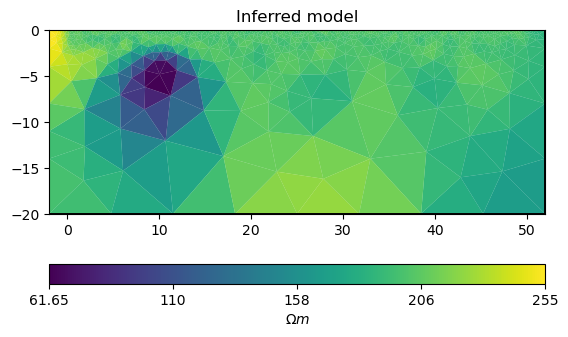

In [19]:
# convert from log space
model = np.exp(inv_result.model)

# plot inferred model
ax = pygimli.show(ert_manager.paraDomain, data=model, label=r"$\Omega m$")
ax[0].set_title("Inferred model")

Text(0.5, 1.0, 'Synthetic data from inferred model')

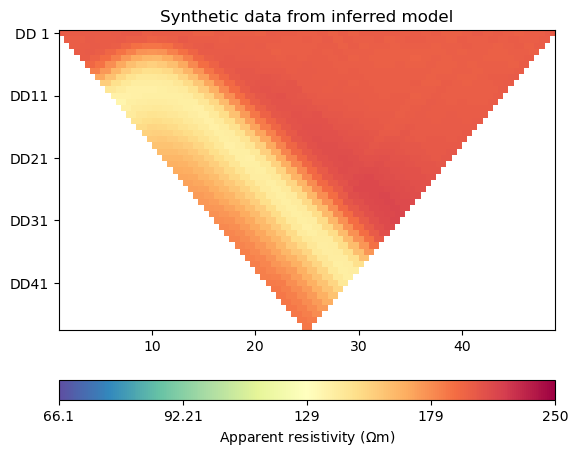

In [20]:
# plot synthetic data
d = forward_oprt.response(model)
ax = ert.showERTData(scheme, vals=d, cMin=np.min(data["rhoa"]), cMax=np.max(data["rhoa"]))
ax[0].set_title("Synthetic data from inferred model")

## 3. What's next?

Now that we've seen the PyGIMLi ERT problem solved by two different inversion approaches through CoFI,
it would be nice to see more inversion solvers (even a sampler!) and a similar problem
defined with a rectangular mesh. If you'd like to see some self-contained examples, head to
[this GitHub folder](https://github.com/inlab-geo/cofi-examples/tree/main/notebooks/pygimli_ert)
to explore more.

<!-- ### 2.3 Bayesian sampling with emcee (exploration)

CoFI needs more assumptions about the problem for a sampler to work - these are
the log of posterior distribution density and walkers' starting positions.

For the log posterior, we define here by specifying `log_prior` and `log_likelihood`.
And CoFI will combine them to get the `log_posterior`. -->

---
## Watermark

In [21]:
watermark_list = ["cofi", "numpy", "scipy", "pygimli", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev9
numpy 1.21.6
scipy 1.9.1
pygimli 1.2.6
matplotlib 3.5.3
emcee 3.1.2


arviz 0.12.1
